* vectorize catchments
* for every catchment and its neighbors find new catchment boundary


In [1]:
%matplotlib inline

import logging
import sys
import os
import copy

import numpy as np
import pylab
import matplotlib.pyplot as plt
import ogr
import fiona
import shapely.geometry, shapely.wkt
from shapely.ops import cascaded_union
import shapely as sl
import networkx as nx

import rtree

from utils.shapely_plot import draw

import glob
import subprocess
from os.path import basename

pylab.rcParams['figure.figsize'] = (17.0, 15.0)
logging.basicConfig(stream=sys.stderr, level=logging.INFO)

In [2]:
def to_shp(input_tif, output_shp, output_dir):
    cmd = r'gdal_polygonize.py {0} -f "ESRI Shapefile" {1} {2} DN'.format(input_tif, output_dir, output_shp)
    subprocess.check_call(cmd, shell=True)    


In [3]:
# catchment_tif_files = glob.glob(r'../output/continents_90_all/catchments/*.tif')
# output_dir = r'../output/continents_90_all/catchments_shp'

catchment_tif_files = glob.glob(r'../output/continents/catchments/*.tif')
output_dir = r'../output/continents/catchments_shp'

def vectorize_all():
    for f in catchment_tif_files:
        input_tif = f
        output_shp = basename(input_tif).split('.')[0]
        to_shp(input_tif, output_shp, output_dir)
        
# vectorize_all()        
    

In [4]:
def get_by_id(features, id):
    for feature in features:
        if feature['properties']['HYBAS_ID'] == id:
            return feature
                
def get_neightbors(features, feature):
    neighbors = []
    
    g1 = shapely.geometry.shape(feature['geometry'])

    for f in features:
        g2 = shapely.geometry.shape(f['geometry'])
        
        if g1.intersects(g2):
            neighbors.append(g2)

    return neighbors

def update_catchment_geometry(id):
    pass


In [5]:
path = r'../shared/HydroBASINS_homogenized.shp'

In [6]:
def build_index(features, name):
    props = rtree.index.Property()
    props.dat_extension = 'data'
    props.idx_extension = 'index'
    idx = rtree.index.Index(name, properties = props, overwrite = True)
    
    for i, f in enumerate(features):
        g = shapely.geometry.shape(f['geometry'])
        if not g.is_valid:
             g = g.buffer(0)
        idx.insert(i, g.bounds, f)
        
    return idx

def open_index(name):
    p = rtree.index.Property()
    p.dat_extension = 'data'
    p.idx_extension = 'index'
    
    return rtree.index.Index(name, properties = p, overwrite = False)

In [7]:
path = r'../shared/HydroBASINS_homogenized.shp'
features = fiona.collection(path, "r")

In [8]:
# build index for all HydroBASINS catchments
idx = build_index(features, 'idx_HydroBASINS')

# open existing index for all HydroBASINS catchments
# idx = open_index('idx_HydroBASINS')

In [24]:
# id = 4070030470.0
#id = 4070030520.0
id = 4060128810.0

catchment = get_by_id(features, id)

# print(catchment['properties'])
  
catchment_geom = shapely.geometry.shape(catchment['geometry'])

intersect_ids = list(idx.intersection(catchment_geom.bounds))

for i in intersect_ids:
    f = features[i]
    print(f['properties'])
        
# catchment_neighbors = get_neightbors(features, catchment)
# print(catchment_neighbors)

OrderedDict([(u'HYBAS_ID', 4050098950.0), (u'NEXT_DOWN', 4050000880.0), (u'NEXT_SINK', 4050000880.0), (u'MAIN_BAS', 4050000880.0), (u'DIST_SINK', 92.1), (u'DIST_MAIN', 92.1), (u'SUB_AREA', 40295.7), (u'UP_AREA', 1935203.8), (u'PFAF_ID', 42213), (u'ENDO', 0), (u'COAST', 0), (u'ORDER', 1), (u'SORT', 11.0)])
OrderedDict([(u'HYBAS_ID', 4060137860.0), (u'NEXT_DOWN', 4060133310.0), (u'NEXT_SINK', 4060000880.0), (u'MAIN_BAS', 4060000880.0), (u'DIST_SINK', 622.8), (u'DIST_MAIN', 622.8), (u'SUB_AREA', 11812.9), (u'UP_AREA', 11812.9), (u'PFAF_ID', 422154), (u'ENDO', 0), (u'COAST', 0), (u'ORDER', 2), (u'SORT', 42.0)])
OrderedDict([(u'HYBAS_ID', 4050128730.0), (u'NEXT_DOWN', 4050098950.0), (u'NEXT_SINK', 4050000880.0), (u'MAIN_BAS', 4050000880.0), (u'DIST_SINK', 521.4), (u'DIST_MAIN', 521.4), (u'SUB_AREA', 21952.9), (u'UP_AREA', 21953.6), (u'PFAF_ID', 42214), (u'ENDO', 0), (u'COAST', 0), (u'ORDER', 2), (u'SORT', 14.0)])
OrderedDict([(u'HYBAS_ID', 4060128810.0), (u'NEXT_DOWN', 4060127650.0), (u'NEX

In [25]:
main_catchments = []
nearest_catchments = []

# new catchments (main)
path = r'../output/catchments_merge/SRTM_90_{0}_catchments.shp'.format(int(id))
print(path)
print('Reading main subcatchments ...')
with fiona.collection(path, "r") as features2:
    for i, f in enumerate(features2):
        g = shapely.geometry.shape(f['geometry'])
        f['properties']['centroid'] = g.centroid
        f['properties']['area'] = g.area
        
        if not g.is_valid:
            g = g.buffer(0)
        
        f['geometry'] = g
        
        main_catchments.append(f)
        
# new catchments (nearest)
print('Reading nearest subcatchments ...')
for i in intersect_ids:
    f = features[i]
    id2 = f['properties']['HYBAS_ID']
    
    if id2 == id:
        print('skipping')
    else:
        path = r'../output/catchments_merge/SRTM_90_{0}_catchments.shp'.format(int(id2))
        print(path)
        if not os.path.exists(path):
            print('skipping, no file')
            continue
            
        with fiona.collection(path, "r") as features2:
            for i, f in enumerate(features2):
                g = shapely.geometry.shape(f['geometry'])
                f['properties']['centroid'] = g.centroid
                f['properties']['area'] = g.area
                
                if not g.is_valid:
                    g = g.buffer(0)
                f['geometry'] = g
        
                nearest_catchments.append(f)        

print('Number of main catchments: ' + str(len(main_catchments)))
print('Number of nearest catchments: ' + str(len(nearest_catchments)))                

../output/catchments_merge/SRTM_90_4060128810_catchments.shp
Reading main subcatchments ...
Reading nearest subcatchments ...


../output/catchments_merge/SRTM_90_4050098950_catchments.shp
../output/catchments_merge/SRTM_90_4060137860_catchments.shp


skipping, no file
../output/catchments_merge/SRTM_90_4050128730_catchments.shp
skipping
../output/catchments_merge/SRTM_90_4060142620_catchments.shp
skipping, no file
../output/catchments_merge/SRTM_90_4060133180_catchments.shp
../output/catchments_merge/SRTM_90_4060133310_catchments.shp
skipping, no file
Number of main catchments: 928
Number of nearest catchments: 11174


In [26]:
idx_main = build_index(main_catchments, 'idx_main')
idx_nearest = build_index(nearest_catchments, 'idx_nearest')

In [28]:
print('Detecting overlaps ...')
overlaps_count = 0
for f in main_catchments:
    g = shapely.geometry.shape(f['geometry'])
    a = f['properties']['area']
    c = f['properties']['centroid']

    intersected = None
    nearest_indices = list(idx_nearest.intersection(g.bounds))
    
    # sub-catchment belongs to currentmain catchment
    is_main = True

    nearest_intersections = []
    for i in nearest_indices:
        n = nearest_catchments[i]
        if g.intersects(n['geometry']): # double-check intersection
            overlaps_count = overlaps_count + 1
            nearest_intersections.append(n)

            # fix geometry if necessary
            g2 = n['geometry']
            a2 = float(n['properties']['area'])
            c2 = g2.centroid
            intersection = g.intersection(g2)
            
            # extent
            if a2 > 0.0001 and intersection.area > 0.6 * a2 and a > a2 * 5:
                g = cascaded_union(shapely.geometry.MultiPolygon([g, g2]))
                if f['properties']['DN'] == 270:
                    print('1: ' + str(n['properties']['DN']))

            # snap
            if a2 > 0.0001 and intersection.area > 0.6 * a and a2 > a * 5:
                is_main = False # belongs to neareast
                #break # double-check! some catchments may not be extended
                if f['properties']['DN'] == 270:
                    print('2: ' + str(n['properties']['DN']))

            # include small
            #if a2 <= 0.0001 and not c.intersects(catchment_geom):
                #is_main = False # belongs to neareast
                #break # double-check! some catchments may not be extended
                #if f['properties']['DN'] == 270:
                #    print('3: ' + str(n['properties']['DN']))

    f['geometry'] = g
    f['properties']['is_main'] = is_main
    f['properties']['nearest_intersections'] = nearest_intersections
    
            
print('Number of overlaps count: ' + str(overlaps_count))            

Detecting overlaps ...
1: 7
Number of overlaps count: 4348


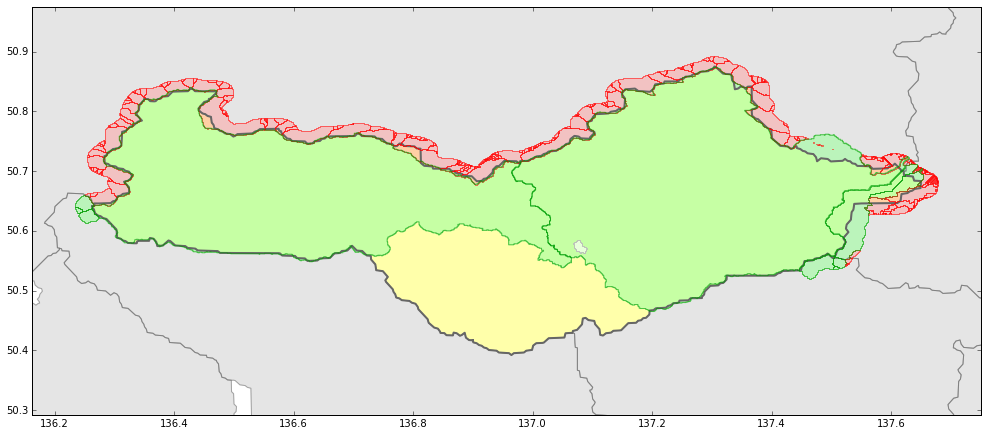

In [23]:
# plot overlapping catchments

fig = plt.figure()
axes = plt.axes()

# axes.set_aspect('equal', 'datalim') # automatically adjust min/max

axes.set_aspect('equal') # set min/max manually
bounds = catchment_geom.bounds
xmargin = 0.1
ymargin = 0.1
pylab.xlim([bounds[0] - xmargin, bounds[2] + xmargin])
pylab.ylim([bounds[1] - ymargin, bounds[3] + ymargin])

# pylab.xlim([74.25, 74.4])
# pylab.ylim([14.50, 14.65])

# pylab.xlim([74.5, 74.6])
# pylab.ylim([14.55, 14.65])

# pylab.xlim([74.5, 74.6])
# pylab.ylim([14.55, 14.65])

# plot geometries
for i in intersect_ids:
    f = features[i]
    g = shapely.geometry.shape(f['geometry'])
    
    draw(g, alpha=0.5)

# plot current catchment
draw(catchment_geom, lw=2.0, fill='#ffffaa')

# plot main sub-catchments
for f in main_catchments:
    g = shapely.geometry.shape(f['geometry'])
    
    is_main = f['properties']['is_main']
    nearest_intersecting = f['properties']['nearest_intersections']

    if any(nearest_intersecting):
        if is_main:
            # belongs to current
            draw(g, outline='#009900', alpha=0.6, fill='#a0ffa0')
        else:
            # belongs to neareast
            draw(g, outline='#ff0000', alpha=0.5, fill='#ffa0a0')
    else:
        #draw(g, outline='#009900', alpha=1.0, fill='#a0ffa0')
        pass

plt.show()

In [ ]:
# merge current

def merge_and_write_main(catchments):
    geoms = []
    
    for f in catchments:
        if f['properties']['is_main']:
            g = f['geometry']
            geoms.append(g)

    geom = cascaded_union(shapely.geometry.MultiPolygon(geoms))
        
    c = copy.deepcopy(catchment)
    c['geometry'] = geom
    
    schema = { 'geometry': 'Polygon', 'properties': {'DN': 'int'}, }

    with fiona.open(shp_path, 'w', 'ESRI Shapefile', schema) as c:
        for f in features:
            c.write({'geometry': mapping(f['geometry']), 'properties': {'DN': f['properties']['DN']}})

path_merged = r'../output/catchments_merge/SRTM_90_{0}_catchments_merged.shp'.format(int(id))
write_shp(merged2, path_merged)